# CQF Exam 2 - Pricing of a Binary Option

## General Setup and Imports

In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm
from collections import namedtuple
from functools import partial

%matplotlib inline

RANDOM_SEED = 100

# Present Valuing (Discount Factor)
# x = r, y = T-t
DF = lambda x, y: math.exp(-x * y)

# Initial setup
S0 = 100      # Stock value at t=0
E = 100       # Strike Price
T = 1         # Time to expiry
r = 0.05      # annulized risk-free interest rate
v = 0.2       # annulized volatility

BinaryOption = namedtuple("BinaryOption", ["name", "c_v", "p_v"])

## Theoretical Black Scholes Binary Call & Put Option Value

In [142]:
def bse_theoretical(S, E, r, v, T, output=True):
    
    # Theoretical Value
    d1 = (np.log(S/E) + (r + 0.5*v**2)*T) / (v* math.sqrt(T))

    d2 = d1 - v*math.sqrt(T)

    # Using Asset or Nothing
    c_an = DF(r, T) * norm.cdf(d2)
    p_an = DF(r, T) * (1 - norm.cdf(d2))

    if output:
        print("="*100, "\n")
        literal = "Asset or Nothing Values"
        print(literal)
        print("-"*(len(literal) + 2), "\n")
        print("Binary Call Option Value:  V(S, T):{:7.3f}".format(c_an))
        print("Binary Put  Option Value:  V(S, T):{:7.3f}".format(p_an))
        print("="*100, "\n")
    
    return BinaryOption("bse_theoretical", c_an, p_an)

option_bse = bse_theoretical(S=S0, E=E, r=r, v=v, T=T)


Asset or Nothing Values
------------------------- 

Binary Call Option Value:  V(S, T):  0.532
Binary Put  Option Value:  V(S, T):  0.419



In [140]:
call_bse_theoretical = lambda x: bse_theoretical(S=x, E=E, r=r, v=v, T=T, output=False).c_v

s = np.arange(1, 301, step=1)
value = np.array(list(map(call_bse_theoretical, s)))

payoff_profile = np.heaviside(s - E, 0)

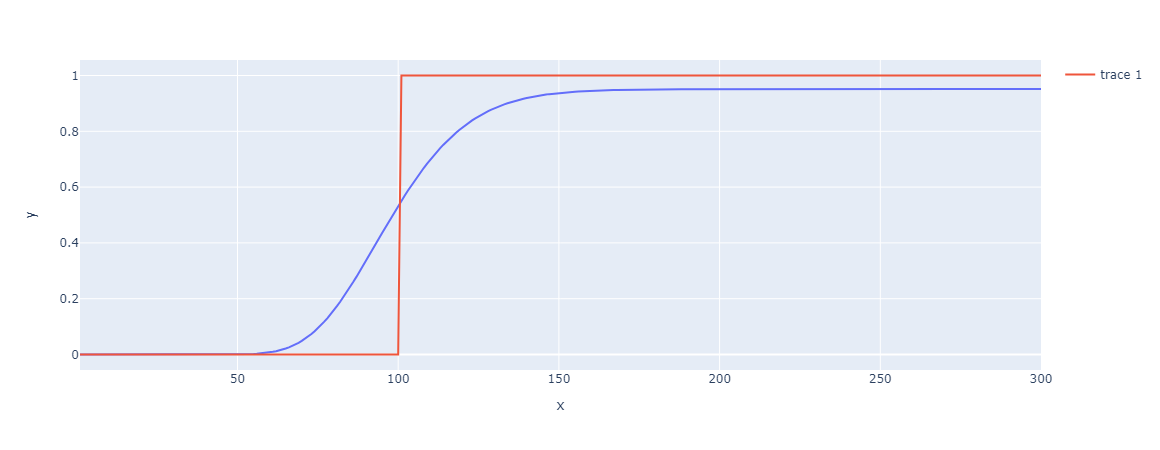

In [141]:
fig = px.line(x=s, y=value)
fig.add_scatter(x=s, y=payoff_profile)
fig.show()

## One Giant Leap Binary Call Value

In [154]:
np.random.seed(RANDOM_SEED)

def bse_giant_leap(S, E, r, v, T, npaths=1E6, plot=True, output=True):
    global option_bse
    
    N = int(npaths)
    
    # Generate some random numbers
    rn = np.random.standard_normal(size=N)

    
    s_t = S*np.exp((r - 0.5*v**2)*T + v*rn*math.sqrt(T))
    
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), dpi=70)

        s_t_norm = (s_t - np.mean(s_t)) / np.std(s_t)

        # Note for self: Pass density=true to normalize it such that integral over distribution = 1
        ax.hist(s_t_norm, bins=1000, density=True)

        ax.set_xlabel("Normalzed Stock price at time T")
        ax.set_ylabel("Frequency");
        ax.set_xlim([-4, 4])

    # Value of Binary Option
    # value = S0 * DF(r, T) * np.heaviside(s_t - strike, 0).mean()
    call_value = DF(r, T) * np.mean(s_t > E)
    put_value = DF(r, T) * np.mean(s_t < E)
    
    if output:
        print("="*100, "\n")
        print("Expected Value: {:7.5f}\n".format(np.mean(s_t))) # TODO: delete later
        literal = "Asset or Nothing Values"
        print(literal)
        print("-"*(len(literal) + 2), "\n")
        print("Binary Call Option Value:  V(S, T):{:7.5f}  | ({:5.5f})".format(call_value, option_bse.c_v))
        print("Binary Put  Option Value:  V(S, T):{:7.5f}  | ({:5.5f})".format(put_value, option_bse.p_v))
        print("="*100, "\n")
    
    return BinaryOption("euler1", call_value, put_value)

_ = bse_giant_leap(S=S0, E=E, r=r, v=v, T=T, npaths=1E6, plot=False)


Expected Value: 105.12437

Asset or Nothing Values
------------------------- 

Binary Call Option Value:  V(S, T):0.53246  | (0.53232)
Binary Put  Option Value:  V(S, T):0.41877  | (0.41890)



In [157]:
call_bse_giant_leep = lambda x: bse_giant_leap(S=x, E=E, r=r, v=v, T=T, plot=False, output=False).c_v

s = np.arange(1, 301, step=1)
value_gl = np.array(list(map(call_bse_giant_leep, s)))

payoff_profile = np.heaviside(s - E, 0)

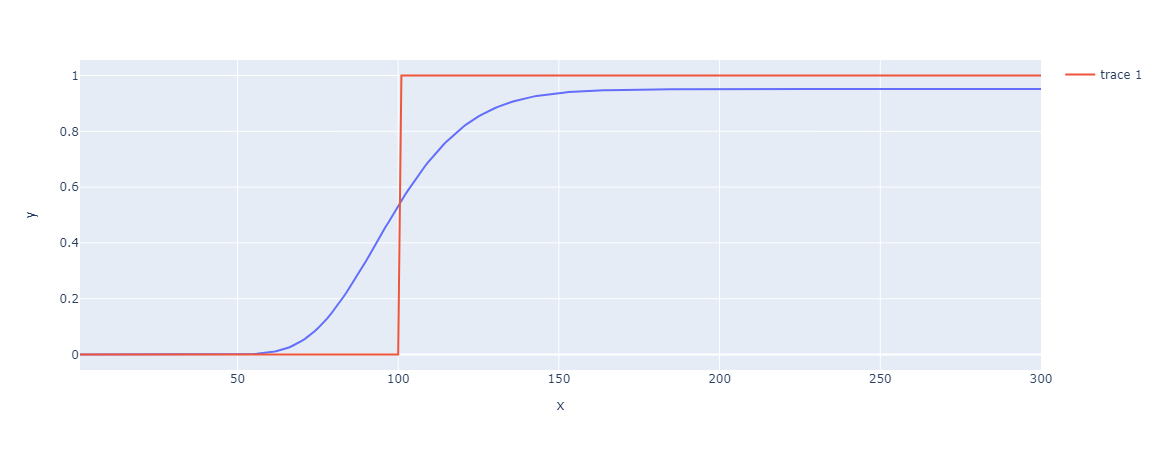

In [158]:
fig = px.line(x=s, y=value_gl)
fig.add_scatter(x=s, y=payoff_profile)
fig.show()

## Euler-Maruyama + Milstein (optional)

In [4]:
np.random.seed(RANDOM_SEED)

def euler(s_grid, rn, dt, r, vol, nsteps=1):
    """
    Executes looping over square grid to generate a random walk.
    ------------------------------------------------------------
    param  sgrid:
    param     dt:
    param      r:
    param    v:
    param nsteps:
    """
    global option_bse
    
    # Manually adjust flags
    mil_on = 1                # set t1 to turn Milstein component on
    exponent_form = False     # Exponential form of the random walk

    # iterate across columns
    if exponent_form:
        exponent = (r - 0.5*(v**2))*dt + (v * rn * (dt**0.5))
        con = np.exp(exponent)

    else:

        a = r * dt
        b = v * rn * dt**0.5
        c = 0.5 * (v**2)*(np.power(rn, 2) - 1) * dt

        con = 1 + a + b + mil_on * c

    # Begin Iteration
    for i in range(0, nsteps):

        s_grid[:, i+1] = s_grid[:, i] * con[:, i]

# Execute below
def euler_maruyama(S, E, r, v, T, npaths=1E4, nsteps=252, plot=False, output=True):
    """
    Main Function to execute
    """
    
    # with N=100,000 and nsteps=252 this consumes up to 500 MB of RAM
    
    N = int(npaths)
    max_paths_to_plot = 1

    M = int(nsteps) + 1
    dt = T / int(nsteps)

    # random number drawn from a standard normal distribution
    # Note this is essentially Cell values, hence M-1, while stock is essentially Point Data in CFD terminology
    rn = np.random.standard_normal(size=N*(M-1)).reshape((N, (M-1)), order="C")

    # Stock prices for each path from 0 to N-1
    s_grid = np.zeros((N, M), order="C")

    # Initial values
    s_grid[:, 0] = S

    # Calculate Stock Price by walking across passed in grid
    euler(s_grid, rn, dt, r, v, nsteps=nsteps)

    # Extract results at end of random walk
    s_t = s_grid[:, -1]
    
    if plot:
        # Plot Random Walk Distribution at expiry
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), dpi=70, sharey=True)
        ax1, ax2 = axes
        plt.tight_layout(pad=1.08, h_pad=None, w_pad=None)
        
        ax1.set_ylabel("S(t)");
        ax2.set_xlabel("Normalized Stock price at time T")

        # Going to use quantile for now to come up with some way of letter y limits scale with varying settings
        c = 5/100/100
        q1, q3 = np.quantile(s_t, (c, 1-c))  # Q1 and Q3 quantiles
        ax2.set_ylim([q1, q3])

        # Plot Histogram
        ax2.hist(s_t, bins=1000, density=True, orientation="horizontal")

        # Plot the paths - No. paths limited by max_paths_to_plot variable :TODO fix this horrible variable name
        x = np.arange(0, M, step=1)
        for i in range(N):

            ax1.plot(x, s_grid[i, :])

            if i > max_paths_to_plot: break
        
        ax1.plot(x, s_grid.mean(axis=0).T)
        ax1.plot(x, np.ones_like(x)*S0, lw=2, color="k")
        ax1.set_xlim([0, nsteps])

    # Calculate Binary Option Value
    call_value = DF(r, T) * np.mean(s_t > E)
    put_value = DF(r, T) * np.mean(s_t < E)
    
    if output:
        print("="*100, "\n")
        print("Expected Value: {:7.5f}\n".format(np.mean(s_t))) # TODO: delete later
        literal = "Asset or Nothing Values"
        print(literal)
        print("-"*(len(literal) + 2), "\n")
        print("Binary Call Option Value:  V(S, T):{:7.2f}  | ({:5.2f})".format(call_value, option_bse.c_v))
        print("Binary Put  Option Value:  V(S, T):{:7.2f}  | ({:5.2f})".format(put_value, option_bse.p_v))
        print("="*100, "\n")
    
    return BinaryOption("euler2", call_value, put_value)

_ = euler_maruyama(S=S0, E=E, r=r, v=v, T=T, npaths=1E4, nsteps=252, plot=False, output=True)


Expected Value: 105.23160

Asset or Nothing Values
------------------------- 

Binary Call Option Value:  V(S, T):  53.50  | (53.23)
Binary Put  Option Value:  V(S, T):  41.63  | (41.89)



# Alternative coding method: Euler-Maruyama + Milstein (optional)
- Just looking for something more memory efficient when number of timesteps and number of paths increase

In [5]:
import time

def euler_alternative(s_t0, s_t1, dt, r, vol, nsteps=1):
    
    np.random.seed(100)
    
    mil_on = 1               # set t1 to turn Milstein component on
    
    dt_sqrt = math.sqrt(dt)  # calculate this only once rather than every loop
    n = s_t0.size
    
    # Begin iteration
    for i in range(nsteps):
        
        # Generate N(0, 1) random numbers 
        rn = np.random.standard_normal(n)
        
        # Calculate value at next time step
        s_t1[:] = s_t0[:] * (1 + (r * dt) + (v * rn * dt_sqrt)
                             + (mil_on * 0.5 * (v**2)*(np.power(rn, 2) - 1) * dt))  # Milstein component
        
        # Setup next time step initial value values
        s_t0[:] = s_t1[:]
    
    return s_t1

def euler_maruyama_alternative(S, E, r, v, T, npaths=1E4, nsteps=252, plot=False, output=True, rtn_st=False):
    """
    Main Function to execute
    
    param npaths:  No. paths to simulate
    param nsteps:  No. time steps
    """
    
    N = int(npaths)
    M = int(nsteps)
    dt = T / M 

    # S_t - Initial stock prices for each path
    s_t0 = np.ones(N, order="C") * S

    # S_t+1 - stock  price at next time step
    s_t1 = np.zeros_like(s_t0)

    # Calculate Stock Price
    s_t = euler_alternative(s_t0, s_t1, dt, r, v, nsteps=nsteps)
    
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=70)

        s_t_norm = (s_t - np.mean(s_t)) / np.std(s_t)

        ax.hist(s_t_norm, bins=int(math.modf(N/10)[1]), range=[-4, 4])
        ax.set_xlabel("Normalized Stock price at time T")
        ax.set_ylabel("Frequency");

    # Calculate Binary Option Value
    call_value = DF(r, T) * np.mean(s_t > E)
    put_value = DF(r, T) * np.mean(s_t < E)
    
    if output:
        print("="*100, "\n")
        print("Expected Value: {:7.5f}\n".format(np.mean(s_t))) # TODO: delete later
        literal = "Asset or Nothing Values"
        print(literal)
        print("-"*(len(literal) + 2), "\n")
        print("Binary Call Option Value:  V(S, T):{:7.2f}  | ({:5.2f})".format(call_value, option_bse.c_v))
        print("Binary Put  Option Value:  V(S, T):{:8.2f}  | ({:5.2f})".format(put_value, option_bse.p_v))
        print("="*100, "\n")
    
    return s_t if rtn_st else BinaryOption("euler3", call_value, put_value)

start = time.time()
option_euler3 = euler_maruyama_alternative(S=S0, E=E, r=r, v=v, T=T, npaths=1E4, nsteps=252, plot=False)
end = time.time()
print("Elapsed (after compilation) = {:7.2f} ms".format(float(end - start)*1000))


Expected Value: 105.21911

Asset or Nothing Values
------------------------- 

Binary Call Option Value:  V(S, T):  53.79  | (53.23)
Binary Put  Option Value:  V(S, T):   41.33  | (41.89)

Elapsed (after compilation) =  136.46 ms


In [14]:
%timeit -n 10 -r 10 euler_maruyama(npaths=1E4, nsteps=252, plot=False, output=False)

225 ms ± 5.39 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [45]:
%timeit -n 10 -r 10 euler_maruyama_alternative(npaths=1E4, nsteps=252, plot=False, output=False)

125 ms ± 2.29 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


# Convergence

In [6]:
import itertools as it

def update_func(prev, curr):
    a_im1 = prev[1]
    i = curr[0]
    s_i = curr[1]
    a_i = (1/i)*s_i + ((i-1)/i)*a_im1
    
    return (i, a_i)

# Small test. This should give cummulative average of the list [1, 2, 3, 4, 5]
cumavg_test = it.accumulate(zip(it.count(1, step=1), [1, 2, 3, 4, 5]), func=update_func)

# Results should be as folows
# Element : Anwer
#       1 : 1
#       2 : (1+2) / 2 = 3/2 = 1.5
#       3 : (1+2+3) / 3 = 6/2 = 2
#       4 : (1+2+3+4) / 4  = 10 / 4 = 2.5
#       5 : (1+2+3+4+5) / 5 = 15 / 5 = 3
# [1, 1.5, 2, 2.5, 3]

# map function simply extracts the 2nd elment from each tuple in the list of tuples
# [(1, 1), (2, 1.5), (3, 2), (4, 2.5), (5, 3)] ---> [1, 1.5, 2, 2.5, 3]
print(list(map(lambda x: x[1], [next(cumavg_test) for _ in range(5)])))

[1, 1.5, 2.0, 2.5, 3.0]


In [8]:
st_conv = euler_maruyama_alternative(npaths=1E4, nsteps=252, plot=False, output=False, rtn_st=True)

In [9]:
eq = it.accumulate(zip(it.count(1, step=1), st_conv), func=update_func)

cumavg = list(map(lambda x: x[1], [next(eq) for _ in range(len(st_conv))]))
print(cumavg[:5])

[131.91236113042987, 114.76778055548017, 113.01243852890455, 104.62386790700572, 108.90938854630824]


In [18]:
delta = np.diff(cumavg)
x = np.arange(len(cumavg))

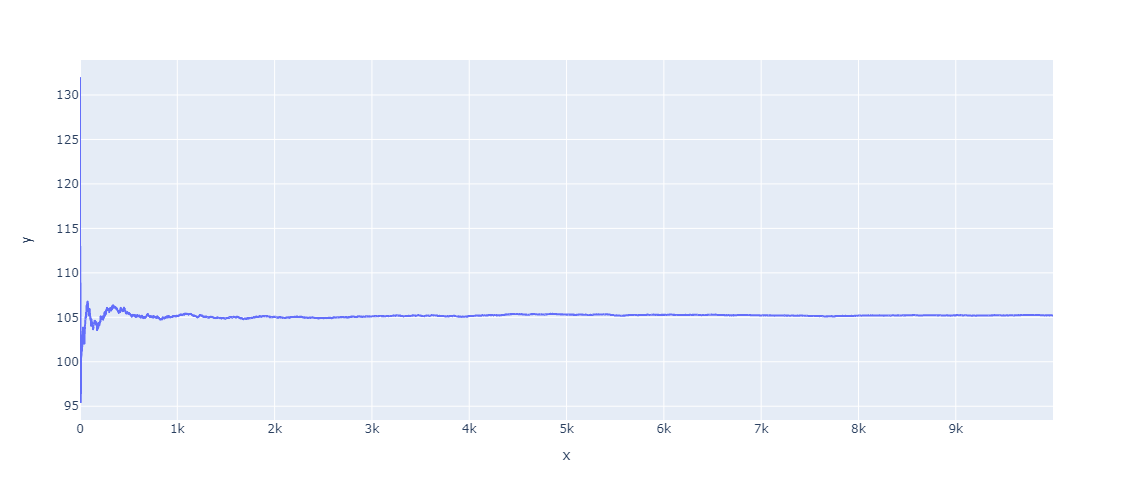

In [20]:

fig = px.line(x=x, y=cumavg, width=1000, height=500)
#fig.update_layout(yaxis_type="log")
fig.show()

From the above figure, it appears that after ~ 4K paths we have converged to a stable average value of the average stock price.

In [42]:
window_sizes = np.arange(10, 10000, step=100)
print(window_sizes)

[  10  110  210  310  410  510  610  710  810  910 1010 1110 1210 1310
 1410 1510 1610 1710 1810 1910 2010 2110 2210 2310 2410 2510 2610 2710
 2810 2910 3010 3110 3210 3310 3410 3510 3610 3710 3810 3910 4010 4110
 4210 4310 4410 4510 4610 4710 4810 4910 5010 5110 5210 5310 5410 5510
 5610 5710 5810 5910 6010 6110 6210 6310 6410 6510 6610 6710 6810 6910
 7010 7110 7210 7310 7410 7510 7610 7710 7810 7910 8010 8110 8210 8310
 8410 8510 8610 8710 8810 8910 9010 9110 9210 9310 9410 9510 9610 9710
 9810 9910]


In [43]:
mean_vals = np.zeros_like(window_sizes)
std_vals = np.zeros_like(window_sizes)

# Can use enumerate. I am just practicing iterators at this point
for i, window in zip(it.count(0, step=1), window_sizes):
    mean_vals[i] = np.mean(st_conv[:window])
    std_vals[i] = np.std(st_conv[:window])

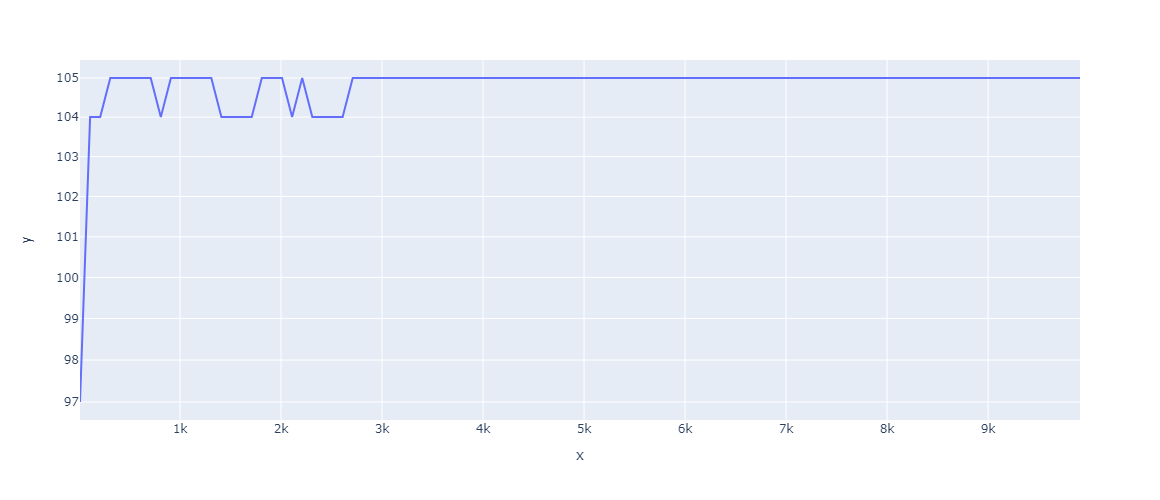

In [47]:
fig = px.line(x=window_sizes, y=mean_vals, width=1000, height=500)
fig.update_layout(yaxis_type="log")
fig.show()

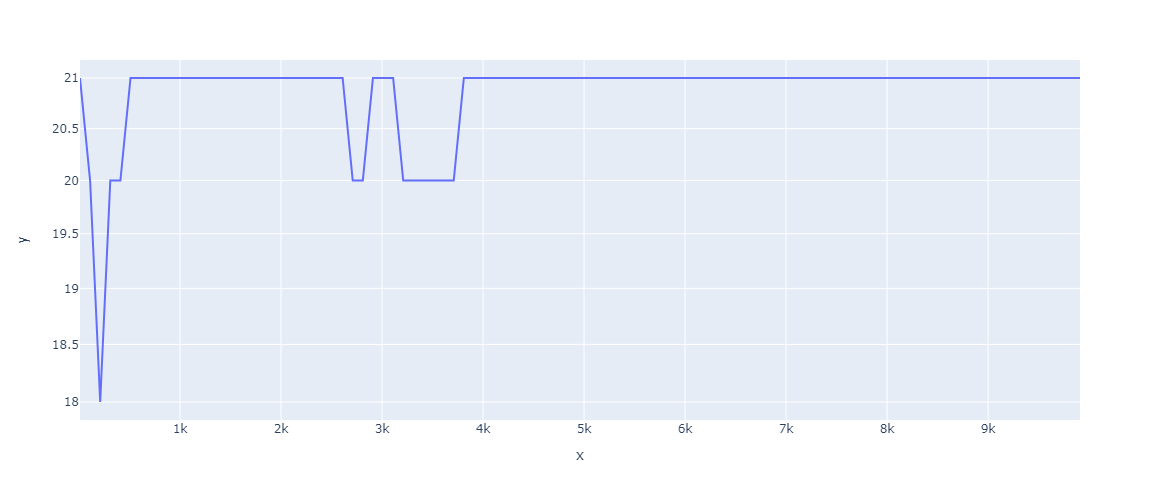

In [49]:
fig = px.line(x=window_sizes, y=std_vals, width=1000, height=500)
fig.update_layout(yaxis_type="log")
fig.show()

It does seem that at ~4K simulations my results are not longer changing by a signigicant amount. <br>
I will be conducting the reamining simulations using a lower number of iterations

# The Greeks

Here we note that we require multiple option values calculated from simulating option prices at spot S and at spot S+$\Delta{S}$ and spot S-$\Delta{S}$.
This means we need to price the option multiple times. However given a path i, the random number for each of the paths must must be the same.
Thus we need to simultaneiously calculate all 3 paths

In [29]:
np.random.seed(RANDOM_SEED)

def euler_greek(sp_t0, sp_t1, s_t0, s_t1, sm_t0, sm_t1, dt, r, vol, nsteps=1):
    
    mil_on = 1               # set t1 to turn Milstein component on
    
    dt_sqrt = math.sqrt(dt)  # calculate this only once rather than every loop
    n = s_t0.size
    
    # Begin iteration
    for i in range(nsteps):
        
        # Generate N(0, 1) random numbers 
        rn = np.random.standard_normal(n)
        
        const = (1 + (r * dt) + (v * rn * dt_sqrt)
                             + (mil_on * 0.5 * (v**2)*(np.power(rn, 2) - 1) * dt))  # Milstein component
        
        # Calculate value at next time step
        sp_t1[:] = sp_t0[:] * const
        s_t1[:] = s_t0[:] * const
        sm_t1[:] = sm_t0[:] * const
        
        # Setup next time step initial value values
        sp_t0[:] = sp_t1[:]
        s_t0[:] = s_t1[:]
        sm_t0[:] = sm_t1[:]
        
    
    return sp_t1, s_t1, sm_t1

def euler_maruyama_greek(S0, E, r, v, T, npaths=1E4, nsteps=252, output=True):
    """
    Main Function to execute
    
    param npaths:  No. paths to simulate
    param nsteps:  No. time steps
    """
    
    global T, S0, E, r, v, DF, option_bse
    
    N = int(npaths)
    M = int(nsteps)
    dt = T / M 
    
    ds = 2
    
    # S at t - Initial stock prices for each path
    sp_t0 = np.ones(N, order="C") * (S0+ds)
    s_t0 = np.ones(N, order="C") * S0
    sm_t0 = np.ones(N, order="C") * (S0-ds)
    
    # S at t+1 - stock  price at next time step
    sp_t1 = np.zeros_like(sp_t0)
    s_t1 = np.zeros_like(s_t0)
    sm_t1 = np.zeros_like(sm_t0)
    
    # Calculate Stock Price
    sp_t, s_t, sm_t = euler_greek(sp_t0, sp_t1,   # S + ds
                                  s_t0, s_t1,      # S
                                  sm_t0, sm_t1,    # S - ds
                                  dt, r, v, nsteps=nsteps)
    
    ## Calculate Binary Option Value
    
    # S + dS
    cp_value = (S0+ds) * DF(r, T) * np.mean(sp_t > E)
    pp_value = (S0+ds) * DF(r, T) * np.mean(s_t < E)
    
    # S
    c_value = S0 * DF(r, T) * np.mean(s_t > E)
    p_value = S0 * DF(r, T) * np.mean(s_t < E)
    
    # S - dS
    cm_value = (S0-ds) * DF(r, T) * np.mean(sm_t > E)
    pm_value = (S0-ds) * DF(r, T) * np.mean(sm_t < E)
    
    # Save Values
    sp_option = BinaryOption("s+ds", cp_value, pp_value)
    s_option = BinaryOption("s", c_value, p_value)
    sm_option = BinaryOption("s-ds", cm_value, pm_value)
    
    if output:
        print("="*100, "\n")
        print("Expected Value: {:7.5f}\n".format(np.mean(s_t))) # TODO: delete later
        literal = "Asset or Nothing Values"
        print(literal)
        print("-"*(len(literal) + 2), "\n")
        
        for option in (sp_option, s_option, sm_option):
            print("Value for {}\n".format(option.name))
            print("Binary Call Option Value:  V(S, T):{:7.2f}  | ({:5.2f})".format(option.c_v, option_bse.c_v))
            print("Binary Put  Option Value:  V(S, T):{:8.2f}  | ({:5.2f})".format(option.p_v, option_bse.p_v))
            print("="*100, "\n")
    
    return sp_option, s_option, sm_option

options = euler_maruyama_greek(npaths=1E6, nsteps=252)


Expected Value: 105.10437

Asset or Nothing Values
------------------------- 

Value for s+ds

Binary Call Option Value:  V(S, T):  57.96  | (53.23)
Binary Put  Option Value:  V(S, T):   42.84  | (41.89)

Value for s

Binary Call Option Value:  V(S, T):  53.13  | (53.23)
Binary Put  Option Value:  V(S, T):   42.00  | (41.89)

Value for s-ds

Binary Call Option Value:  V(S, T):  48.35  | (53.23)
Binary Put  Option Value:  V(S, T):   44.88  | (41.89)



Now lets try calculating the greeks with the various option values

In [121]:
fig = go.Figure(data=[go.Surface(z=grid_data[0], x=grid_data[1], y=grid_data[2], colorscale='Viridis', showscale=True)],
                layout=go.Layout(width=800, height=600, template="seaborn", autosize=False,
                                margin=dict(l=5, r=5, b=5, t=5)))
config = {
    "displaylogo": False,
    "responsive" : False,
    "scrollZoom": False,
    "modeBarButtonsToRemove": ["orbitRotation"]
}
fig.update_layout(scene=dict(xaxis_title="Asset", yaxis_title="Time to Maturity", zaxis_title="Option Price"))
#fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=False))
fig.show(config=config)